In [1]:
from obspy.core import Stream, read
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import pandas as pd
import os 
import os.path

In [7]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)
earthquakes = earthquakes.iloc[[29]]
stas = ['B933']
rows_for_extra_times = [8,9,14,16]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

earthquakes

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
29,2010-01-10T00:27:39.320Z,40.652,-124.6925,28.737,6.5,mw,51,220,0.3225,0.2,...,2022-08-05T23:26:47.399Z,"37 km WNW of Ferndale, California",earthquake,0.55,1.31,NaN,8,reviewed,nc,nc


In [8]:
dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

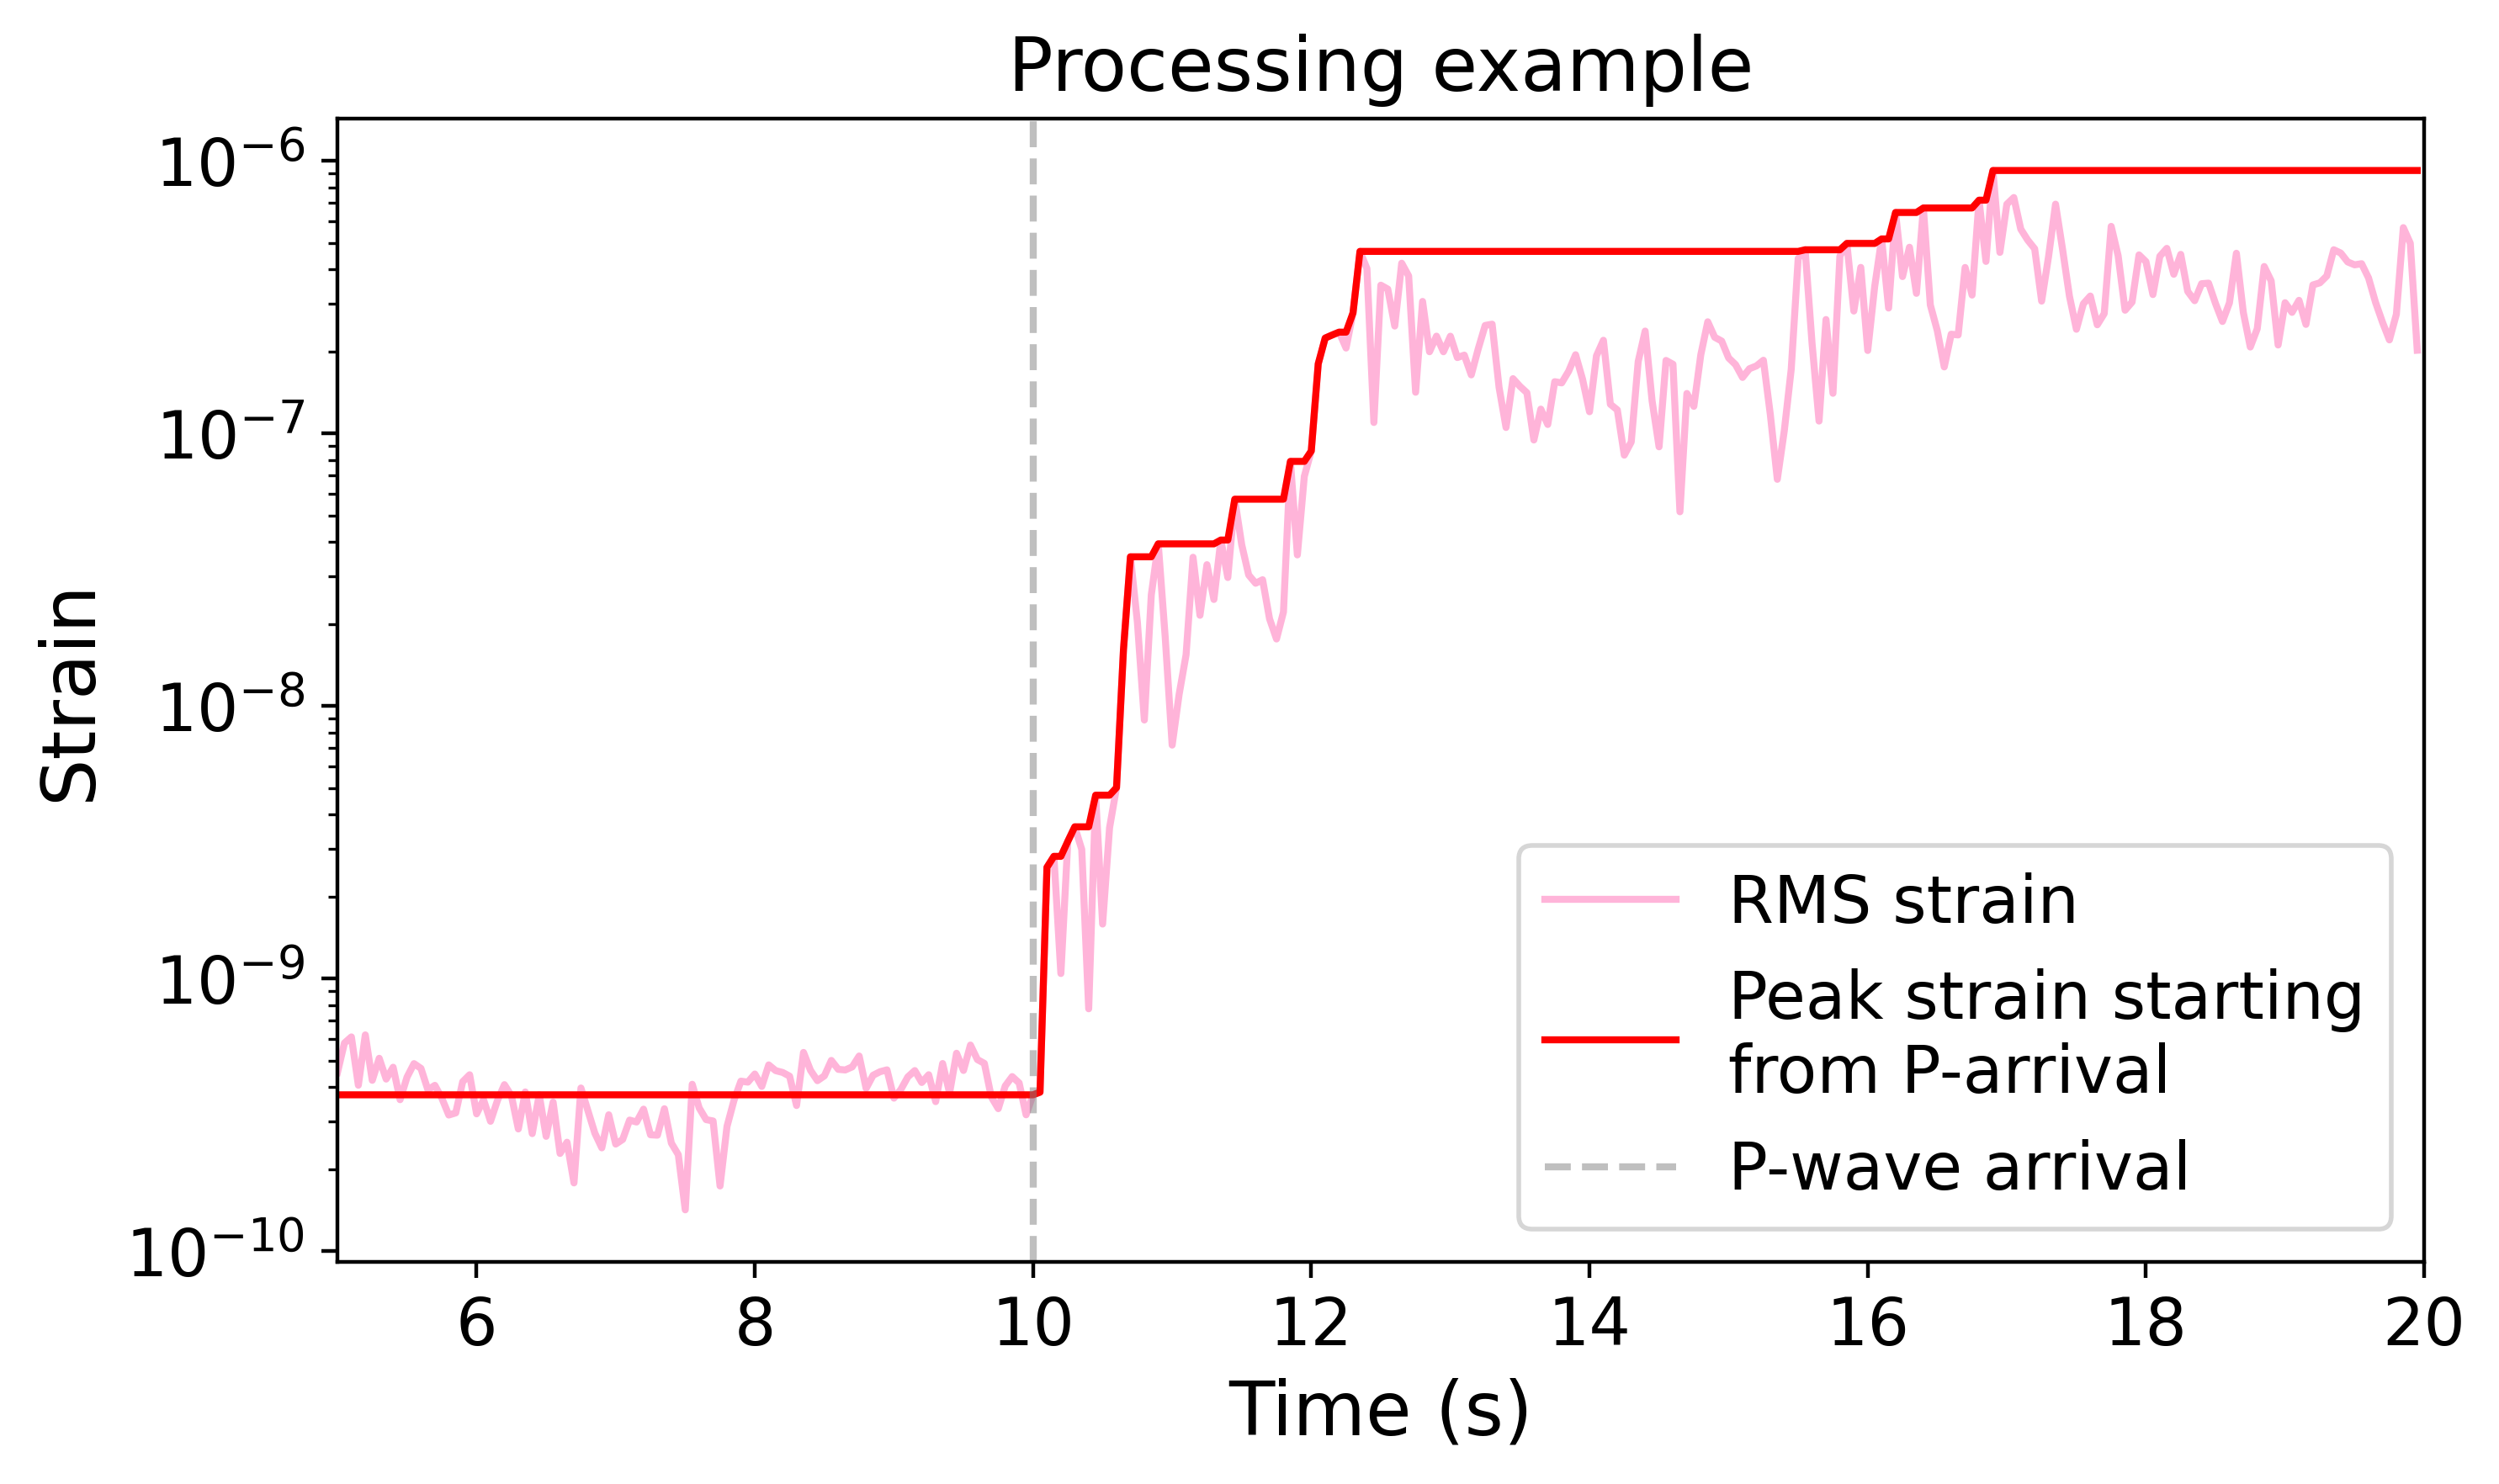

In [42]:
for idx in range(len(earthquakes)):
        
    ot = origin_times[idx]
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
#     print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
#     print(dist_array[i])
    
    for sta in stas:
        
#         print(sta)
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = int(float(dist_array[i][j][0][9]))
        
            # Read in data - peak strain data only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/peak/' + str(eq_id) + '/' + str(sta) + '.mseed')
            pst_postp = read(path_to_files + 'strain_data/peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
            strain_waves = read(path_to_files + 'strain_data/trimmed/' + str(eq_id) + '/' + str(sta) + '.mseed')
            seis_waves = read(path_to_files + 'seismic_data/trimmed/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station
            
        pst_times = pst[0].times()
        pst_data = pst[0].data
        pst_postp_times = pst_postp[0].times()
        pst_postp_data = pst_postp[0].data
        strain_waves_times = strain_waves[0].times()
        strain_waves_data = strain_waves[0].data
        seis_waves_times = seis_waves[0].times()
        seis_waves_data = seis_waves[0].data
        
        samp_rate = pst[0].stats.sampling_rate
        seis_samp_rate = seis_waves[0].stats.sampling_rate

        low_xlim_sec = 5
        high_xlim_sec = 20

        low_xlim_samp = int(low_xlim_sec * samp_rate)
        high_xlim_samp = int(high_xlim_sec * samp_rate)
        
        seis_low_xlim_samp = int(low_xlim_sec * seis_samp_rate)
        seis_high_xlim_samp = int(high_xlim_sec * seis_samp_rate)
        max_seis = max(seis_waves_data)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_data = np.copy(pst_postp_data)
        norm_level = pst_postp_data[0]
#         print(norm_level)
        norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        # Plot stations, but avoid plotting the weird stations for the two problem earthquakes
            
        fig = plt.figure(figsize = (8,4.5), dpi = 400, facecolor = 'white', num = 1, clear = True)
        ax = fig.add_subplot(111)
        
        ax.set_title('Processing example', fontsize = 16)
        ax.plot(strain_waves_times[low_xlim_samp:high_xlim_samp], strain_waves_data[low_xlim_samp:high_xlim_samp], color = '#ffb4d9', label = 'RMS strain')
        ax.plot(pst_postp_times[low_xlim_samp:high_xlim_samp], pst_postp_data[low_xlim_samp:high_xlim_samp], color = 'red', label = 'Peak strain starting\nfrom P-arrival')
        # ax.plot(pst_times[low_xlim_samp:high_xlim_samp], pst_data[low_xlim_samp:high_xlim_samp]*10**9, color = 'skyblue', linestyle = '--', label = 'Prelim. peak strain')
        ax.set_yscale('log')
        ax.set_ylabel('Strain', fontsize = 16)
        ax.set_xlabel('Time (s)', fontsize = 16)
        ax.set_xlim(low_xlim_sec,high_xlim_sec)
        if high_xlim_sec <= 30:
            ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5, label = 'P-wave arrival')
        ax.tick_params(labelsize = 14)
        ax.legend(loc = 'lower right', ncol = 1, fontsize = 14)
        
        # ax2 = ax.twinx()
        # ax2.plot(seis_waves_times[seis_low_xlim_samp:seis_high_xlim_samp], seis_waves_data[seis_low_xlim_samp:seis_high_xlim_samp]/max_seis, color = 'green', alpha = 0.5, label = 'EHZ seismic data')
        # ax2.set_ylabel('Normalized counts', fontsize = 15)
        # ax2.tick_params(labelsize = 13)
        # ax2.legend(loc = 'lower left', fontsize = 10)
        
        plt.show();

        # plt.savefig(path_to_files + 'rms_peak_strain_example_section_2.png', format = 'PNG')
        # plt.close();

In [44]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)
earthquakes = earthquakes.iloc[[1]]
stas = ['B028']
rows_for_extra_times = [8,9,14,16]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

earthquakes

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
1,2022-12-20T10:34:24.770Z,40.525,-124.423,17.91,6.4,mw,38,214,0.0818,0.18,...,2023-12-13T02:59:56.915Z,"15km WSW of Ferndale, CA",earthquake,0.67,0.4,NaN,0,reviewed,nc,nc


In [50]:
for idx in range(len(earthquakes)):
        
    ot = origin_times[idx]
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
#     print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
#     print(dist_array[i])
    
    for sta in stas:
        
#         print(sta)
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = int(float(dist_array[i][j][0][9]))
        
            # Read in data - peak strain data only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/peak/' + str(eq_id) + '/' + str(sta) + '.mseed')
            pst_postp = read(path_to_files + 'strain_data/peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
            strain_waves = read(path_to_files + 'strain_data/trimmed/' + str(eq_id) + '/' + str(sta) + '.mseed')
            seis_waves = read(path_to_files + 'seismic_data/trimmed/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station
            
        pst_times = pst[0].times()
        pst_data = pst[0].data
        pst_postp_times = pst_postp[0].times()
        pst_postp_data = pst_postp[0].data
        strain_waves_times = strain_waves[0].times()
        strain_waves_data = strain_waves[0].data
        seis_waves_times = seis_waves[0].times()
        seis_waves_data = seis_waves[0].data
        
        samp_rate = pst[0].stats.sampling_rate
        seis_samp_rate = seis_waves[0].stats.sampling_rate

        low_xlim_sec = 5
        high_xlim_sec = 40

        low_xlim_samp = int(low_xlim_sec * samp_rate)
        high_xlim_samp = int(high_xlim_sec * samp_rate)
        
        seis_low_xlim_samp = int(low_xlim_sec * seis_samp_rate)
        seis_high_xlim_samp = int(high_xlim_sec * seis_samp_rate)
        max_seis = max(seis_waves_data)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_data = np.copy(pst_postp_data)
        norm_level = pst_postp_data[0]
#         print(norm_level)
        norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        # Plot stations, but avoid plotting the weird stations for the two problem earthquakes
            
        fig = plt.figure(figsize = (8,4.5), dpi = 400, facecolor = 'white', num = 1, clear = True)
        ax = fig.add_subplot(111)
        
        ax.set_title('Two-stage growth example', fontsize = 16)
        # ax.plot(strain_waves_times[low_xlim_samp:high_xlim_samp], strain_waves_data[low_xlim_samp:high_xlim_samp], color = '#ffb4d9', label = 'RMS strain')
        ax.plot(pst_postp_times[low_xlim_samp:high_xlim_samp], pst_postp_data[low_xlim_samp:high_xlim_samp], color = 'red', label = 'Peak strain starting\nfrom P-arrival')
        # ax.plot(pst_times[low_xlim_samp:high_xlim_samp], pst_data[low_xlim_samp:high_xlim_samp]*10**9, color = 'skyblue', linestyle = '--', label = 'Prelim. peak strain')
        ax.set_yscale('log')
        ax.set_ylabel('Strain', fontsize = 16)
        ax.set_xlabel('Time (s)', fontsize = 16)
        ax.set_xlim(low_xlim_sec,high_xlim_sec)
        # if high_xlim_sec <= 30:
        ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5, label = 'P-wave arrival')
        ax.tick_params(labelsize = 14)
        ax.legend(loc = 'lower right', ncol = 1, fontsize = 14)
        
        # ax2 = ax.twinx()
        # ax2.plot(seis_waves_times[seis_low_xlim_samp:seis_high_xlim_samp], seis_waves_data[seis_low_xlim_samp:seis_high_xlim_samp]/max_seis, color = 'green', alpha = 0.5, label = 'EHZ seismic data')
        # ax2.set_ylabel('Normalized counts', fontsize = 15)
        # ax2.tick_params(labelsize = 13)
        # ax2.legend(loc = 'lower left', fontsize = 10)
        
        # plt.show();

        plt.savefig(path_to_files + 'two-stage_example_section_3.png', format = 'PNG')
        plt.close();